# View Filters with PySynphot

- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 24th 2020
- update date :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

import matplotlib.cm as cm
import matplotlib as mpl
cmap = cm.jet

import pysynphot as S
from scipy.interpolate import interp1d
import astropy.units as u
from astropy import constants as const
from astropy.io import fits


PATH_LSSTFiltersKG='../data/lsst/LSSTFiltersKG'
PATH_ATMDATADIR="../data/atm"

sys.path.append(PATH_LSSTFiltersKG)
sys.path.append(PATH_ATMDATADIR)


import libLSSTFiltersKG as lsst

liblsstfilter_path= ../data/lsst/LSSTFiltersKG


In [4]:
def GetAtmosphericProfiles():
    """

    GetAtmosphericProfiles() : Get all the simulated atmospheric profilesprofiles

    :return:
     wl : wavelength
     transm : atmospheric transmission

    """

    # list of input files
    atmospheric_basename_files=os.listdir(PATH_ATMDATADIR)

    idx = 0
    all_data = []
    all_hdr = []
    all_wl = []
    # loop on atmospheric files
    for file in atmospheric_basename_files:
        inputfile = os.path.join(PATH_ATMDATADIR, file)
        hdu = fits.open(inputfile)
        all_hdr.append(hdu[0].header)
        all_data.append(hdu[0].data[1:, :])
        all_wl.append(hdu[0].data[0, :])
        idx += 1
        hdu.close()

    data = np.vstack(all_data)
    hdr = all_hdr[0]

    NbAtmSimul = hdr['NBATMSIM']
    idx_out_num = hdr['ID_NUM']
    idx_out_year = hdr['ID_YEAR']
    idx_out_am = hdr['ID_AM']
    idx_out_vaod = hdr['ID_VAOD']
    idx_out_pwv = hdr['ID_PWV']
    idx_out_o3 = hdr['ID_O3']
    idx_out_cld = hdr['ID_CLD']
    idx_out_res = hdr['ID_RES']

    vaod = data[1:, idx_out_vaod]  # vertical aerosol depth
    pwv = data[1:, idx_out_pwv]  # precipitable water vapor (mm)
    o3 = data[1:, idx_out_o3]  # ozone
    cld = data[1:, idx_out_cld]  # clouds (not used)

    # Extract wavelength and transmission
    wl = all_wl[0][idx_out_res:]
    transm = data[:, idx_out_res:]

    return wl,transm


In [5]:
##----

NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0                      # LSST Exposure time

#------------------------------------------------------------------------------------------
#  Compute the multiplicative factor as calcilated for SpectractorSim to be used for AuxTel
#-------------------------------------------------------------------------------------------
Tel_Surf=LSST_COLL_SURF*(u.cm)**2            # collection surface of telescope
Time_unit=1*u.s                              # flux for 1 second
SED_unit=1*u.erg/u.s/(u.cm)**2/(u.nanometer) # Units of SEDs in flam (erg/s/cm2/nm)
hc=const.h*const.c                           # h.c product of fontamental constants c and h 
wl_dwl_unit=(u.nanometer)**2                 # lambda.dlambda  in wavelength in nm
g_elec=3.0                                   # electronic gain : elec/ADU
g_disperser_ronchi=0.2                       # theoretical gain for order+1 : 20%
#Factor=2.1350444e11
Factor=(Tel_Surf*SED_unit*Time_unit*wl_dwl_unit/hc/g_elec*g_disperser_ronchi).decompose()
#-------------------------------------------------------------------------------------------------

graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
      area: 350000.0
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


# Start

In [6]:
# power law
#-----------
#plt.figure()
#pl = S.PowerLaw(10000, -2,waveunits='Angstrom',fluxunits='flam')
#plt.loglog(pl.wave, pl.flux)
#plt.axvline(10000, ls='--', color='k')
#plt.axhline(1, ls='--', color='k')
#plt.xlabel(pl.waveunits)
#plt.ylabel(pl.fluxunits)
#plt.title(pl.name)
#plt.show()

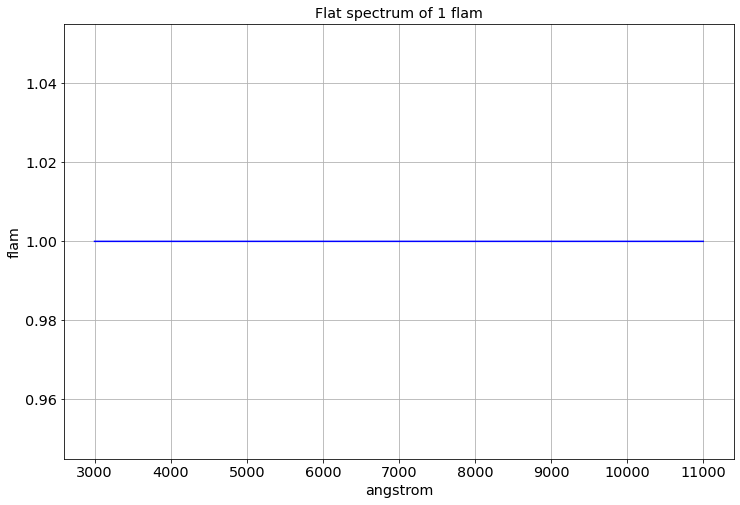

In [7]:
# 1) get a typical spectrum in flam unit (erg/sec/cm)
#-----------------------------------------------------
plt.figure()
flatsp = S.FlatSpectrum(1, fluxunits='flam')
plt.plot(flatsp.wave, flatsp.flux,'b-')
plt.xlabel(flatsp.waveunits)
plt.ylabel(flatsp.fluxunits)
plt.title(flatsp.name)
plt.grid()
plt.show()
    

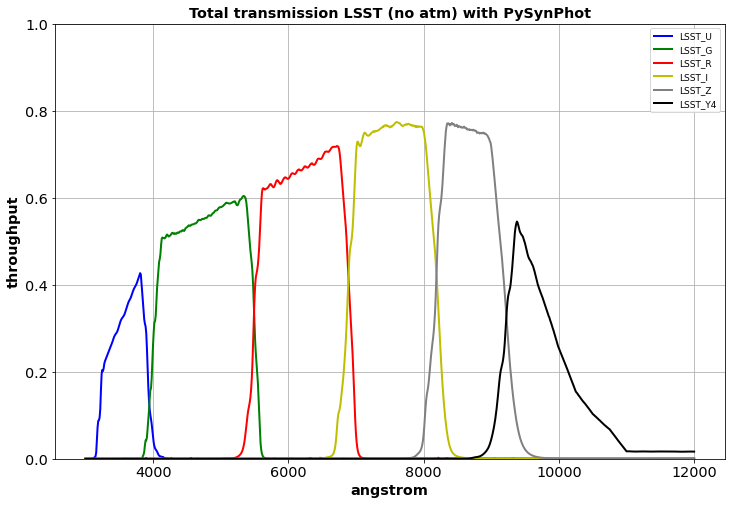

In [8]:
#  2) Read LSST passband in Angstrom
#-------------------------------------------------------
bp_u,bp_g,bp_r,bp_i,bp_z,bp_y=lsst.GetAllLSSTBands("../data/lsst")
lsst.PlotAllLSSTBands(bp_u,bp_g,bp_r,bp_i,bp_z,bp_y)

In [9]:
 # 3) atmosphere simulation with libradtran
#--------------------------------------------------

wl,transm=GetAtmosphericProfiles()
N=transm.shape[0]
idx_atm=0
thetransm=transm[idx_atm,:]

# create the passband
bp_atm=S.ArrayBandpass(wl*10,  thetransm, name='atm_transm')

plt.figure()
plt.plot(bp_atm.wave, bp_atm.throughput,'b-')

plt.grid()
plt.title("Atmospheric transmission")
plt.xlabel("$\\lambda$ nm")
plt.show()

IsADirectoryError: [Errno 21] Is a directory: '../data/atm/lsst_atm_10year_bintab.parquet'

In [ ]:
# calculate by hand the passband product
final_pb_u=bp_u*bp_atm
final_pb_g=bp_g*bp_atm
final_pb_r=bp_r*bp_atm
final_pb_i=bp_i*bp_atm
final_pb_z=bp_z*bp_atm
final_pb_y=bp_y*bp_atm

In [ ]:
# 6) Convert the SED in PHOTLAM
#------------------------------------
flatsp.convert('photlam')  # before multiplication the spectrum must be transformed in photlam
plt.figure()
plt.plot(flatsp.wave, flatsp.flux,'b-')
plt.xlabel(flatsp.waveunits)
plt.ylabel(flatsp.fluxunits)
plt.title(flatsp.name)
plt.grid()
plt.show()

In [ ]:
# 7) Get the true spectrum observed by multiplying the SED in Photlam by the passband
#-------------------------------------------------------------------------------------

final_flux_u=S.Observation(flatsp,final_pb_u)
final_flux_g=S.Observation(flatsp,final_pb_g)
final_flux_r=S.Observation(flatsp,final_pb_r)
final_flux_i=S.Observation(flatsp,final_pb_i)
final_flux_z=S.Observation(flatsp,final_pb_z)
final_flux_y=S.Observation(flatsp,final_pb_y)

In [ ]:
# 8) Show the resulting plots
#------------------------------------------------------------------------------------------

# 8.1) The passband
#--------------------
plt.figure()
plt.plot(final_pb_u.wave,final_pb_u.throughput,'b:')
plt.xlabel(final_pb_u.waveunits.name)
#plt.ylabel(final_pb_u.throughputunits.name)
plt.plot(final_pb_g.wave,final_pb_g.throughput,'g:')
plt.plot(final_pb_r.wave,final_pb_r.throughput,'r:')
plt.plot(final_pb_i.wave,final_pb_i.throughput,'y:')
plt.plot(final_pb_z.wave,final_pb_z.throughput,'k:')
plt.plot(final_pb_y.wave,final_pb_y.throughput,'k:')
plt.title('8.1 : the Passband of LSST')
plt.grid()
plt.show()


In [ ]:
#------------------------------------------------------------------------------------------------------

# 8.2) The passband * wavelength
# --------------------
plt.figure()
plt.plot(final_pb_u.wave,final_pb_u.throughput*final_pb_u.wave/(S.units.C*S.units.H),'b:')
plt.xlabel(final_pb_u.waveunits.name)
#plt.ylabel(final_pb_u.throughputunits.name)
plt.plot(final_pb_g.wave,final_pb_g.throughput*final_pb_g.wave/(S.units.C*S.units.H),'g:')
plt.plot(final_pb_r.wave,final_pb_r.throughput*final_pb_r.wave/(S.units.C*S.units.H),'r:')
plt.plot(final_pb_i.wave,final_pb_i.throughput*final_pb_i.wave/(S.units.C*S.units.H),'y:')
plt.plot(final_pb_z.wave,final_pb_z.throughput*final_pb_z.wave/(S.units.C*S.units.H),'k:')
plt.plot(final_pb_y.wave,final_pb_y.throughput*final_pb_y.wave/(S.units.C*S.units.H),'k:')
plt.title('8.2 : Passband * WL')
plt.grid()
plt.show()    

In [ ]:
# 8.3) The Observed flux
#---------------------------------------------------------------------------------
plt.figure()
plt.plot(final_flux_u.wave,final_flux_u.flux,'b-.')
plt.xlabel(final_flux_u.waveunits.name)
plt.ylabel(final_flux_u.fluxunits.name)
plt.plot(final_flux_g.wave,final_flux_g.flux,'g-.')
plt.plot(final_flux_r.wave,final_flux_r.flux,'r-.')
plt.plot(final_flux_i.wave,final_flux_i.flux,'y-.')
plt.plot(final_flux_z.wave,final_flux_z.flux,'k-.')
plt.plot(final_flux_y.wave,final_flux_y.flux,'k-.')
plt.title('8.3) : Flux computed by Pysynphot::Observation after conversion of flux into PhotLam')
plt.grid()
plt.show()